<a href="https://colab.research.google.com/github/ostaazi/Hybrid-Deep-Learning-and-Computer-Vision-Framework-for-Accurate-Brain-Tumor-Detection-from-MRI-Scans/blob/main/Copy_of_Copy_of_fixed_Brain_Tumor_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ============================================
# Cell 2 – Mount Google Drive & define project directories
# ============================================

from google.colab import drive
import os

drive.mount("/content/drive")

# مجلد المشروع الرئيسي على درايف
PROJECT_DIR = "/content/drive/MyDrive/brats_brainvision_brats2020"
RGB_DIR = os.path.join(PROJECT_DIR, "brats2020_rgb_slices_256")
CHECKPOINT_DIR = os.path.join(PROJECT_DIR, "checkpoints")
EVAL_DIR = os.path.join(PROJECT_DIR, "evaluation")
EXPERIMENTS_DIR = os.path.join(PROJECT_DIR, "experiments")
GALLERY_DIR = os.path.join(PROJECT_DIR, "results_gallery")

for d in [PROJECT_DIR, RGB_DIR, CHECKPOINT_DIR, EVAL_DIR, EXPERIMENTS_DIR, GALLERY_DIR]:
    os.makedirs(d, exist_ok=True)

print("PROJECT_DIR :", PROJECT_DIR)
print("RGB_DIR     :", RGB_DIR)
print("CHECKPOINT_DIR:", CHECKPOINT_DIR)
print("EVAL_DIR    :", EVAL_DIR)
print("EXPERIMENTS_DIR:", EXPERIMENTS_DIR)
print("GALLERY_DIR :", GALLERY_DIR)


Mounted at /content/drive
PROJECT_DIR : /content/drive/MyDrive/brats_brainvision_brats2020
RGB_DIR     : /content/drive/MyDrive/brats_brainvision_brats2020/brats2020_rgb_slices_256
CHECKPOINT_DIR: /content/drive/MyDrive/brats_brainvision_brats2020/checkpoints
EVAL_DIR    : /content/drive/MyDrive/brats_brainvision_brats2020/evaluation
EXPERIMENTS_DIR: /content/drive/MyDrive/brats_brainvision_brats2020/experiments
GALLERY_DIR : /content/drive/MyDrive/brats_brainvision_brats2020/results_gallery


In [ ]:
!pip install -q nibabel opencv-python-headless tqdm



In [ ]:
!pip install -q "tensorflow==2.18.0"



In [ ]:
!pip uninstall -y jax jaxlib


Found existing installation: jax 0.7.2
Uninstalling jax-0.7.2:
  Successfully uninstalled jax-0.7.2
Found existing installation: jaxlib 0.7.2
Uninstalling jaxlib-0.7.2:
  Successfully uninstalled jaxlib-0.7.2


In [ ]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)



TensorFlow version: 2.18.0


In [ ]:
# ============================================
# Cell 1 – Download BraTS2020 dataset via KaggleHub
# ============================================
# هذه الخلية تُشغَّل مرة واحدة لكل Runtime (أو عند الحاجة)

!pip install -q kagglehub

import kagglehub

print("Downloading BraTS2020 dataset from KaggleHub...")
brats_root = kagglehub.dataset_download("awsaf49/brats20-dataset-training-validation")
print("Dataset root path:", brats_root)

# سنحاول بناء المسار القياسي لملفات التدريب داخل الدataset
import os

default_train_subdir = os.path.join(
    brats_root,
    "BraTS2020_TrainingData",
    "MICCAI_BraTS2020_TrainingData"
)

if os.path.isdir(default_train_subdir):
    TRAIN_DATASET_PATH = default_train_subdir
else:
    # fallback لمسار بيئة Kaggle/Colab التلقائي
    fallback_path = "/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
    if os.path.isdir(fallback_path):
        TRAIN_DATASET_PATH = fallback_path
    else:
        raise RuntimeError(
            "لم أجد مجلد التدريب داخل الداتا.\n"
            "تحقق من محتويات brats_root أو عدّل TRAIN_DATASET_PATH يدويًا."
        )

print("TRAIN_DATASET_PATH:", TRAIN_DATASET_PATH)


Using Colab cache for faster access to the 'brats20-dataset-training-validation' dataset.
Dataset root path: /kaggle/input/brats20-dataset-training-validation
TRAIN_DATASET_PATH: /kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData


TRANSFORMING BRATS2020 TO RGB (TRAINING SLICES ONLY)
Input TRAIN_DATASET_PATH: /kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData
Found 369 cases
Processing slices: 22 to 121
Output size: 256x256
Total slices per case to save: 100
OUTPUT_DIR: /content/drive/MyDrive/brats_brainvision_brats2020/brats2020_rgb_slices_256

Step 1: Creating healthy templates...


✓ Created templates from 200 healthy slices
Template shape: (240, 240)

Step 2: Processing cases and saving RGB + masks to Google Drive...


Transforming cases: 100%|██████████| 369/369 [00:01<00:00, 260.27it/s]


[ERROR] BraTS20_Training_355: No such file or no access: '/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/BraTS20_Training_355_seg.nii'

TRANSFORMATION COMPLETE
Processed cases : 0
Skipped (already done): 368
Errors          : 1
Output directory: /content/drive/MyDrive/brats_brainvision_brats2020/brats2020_rgb_slices_256


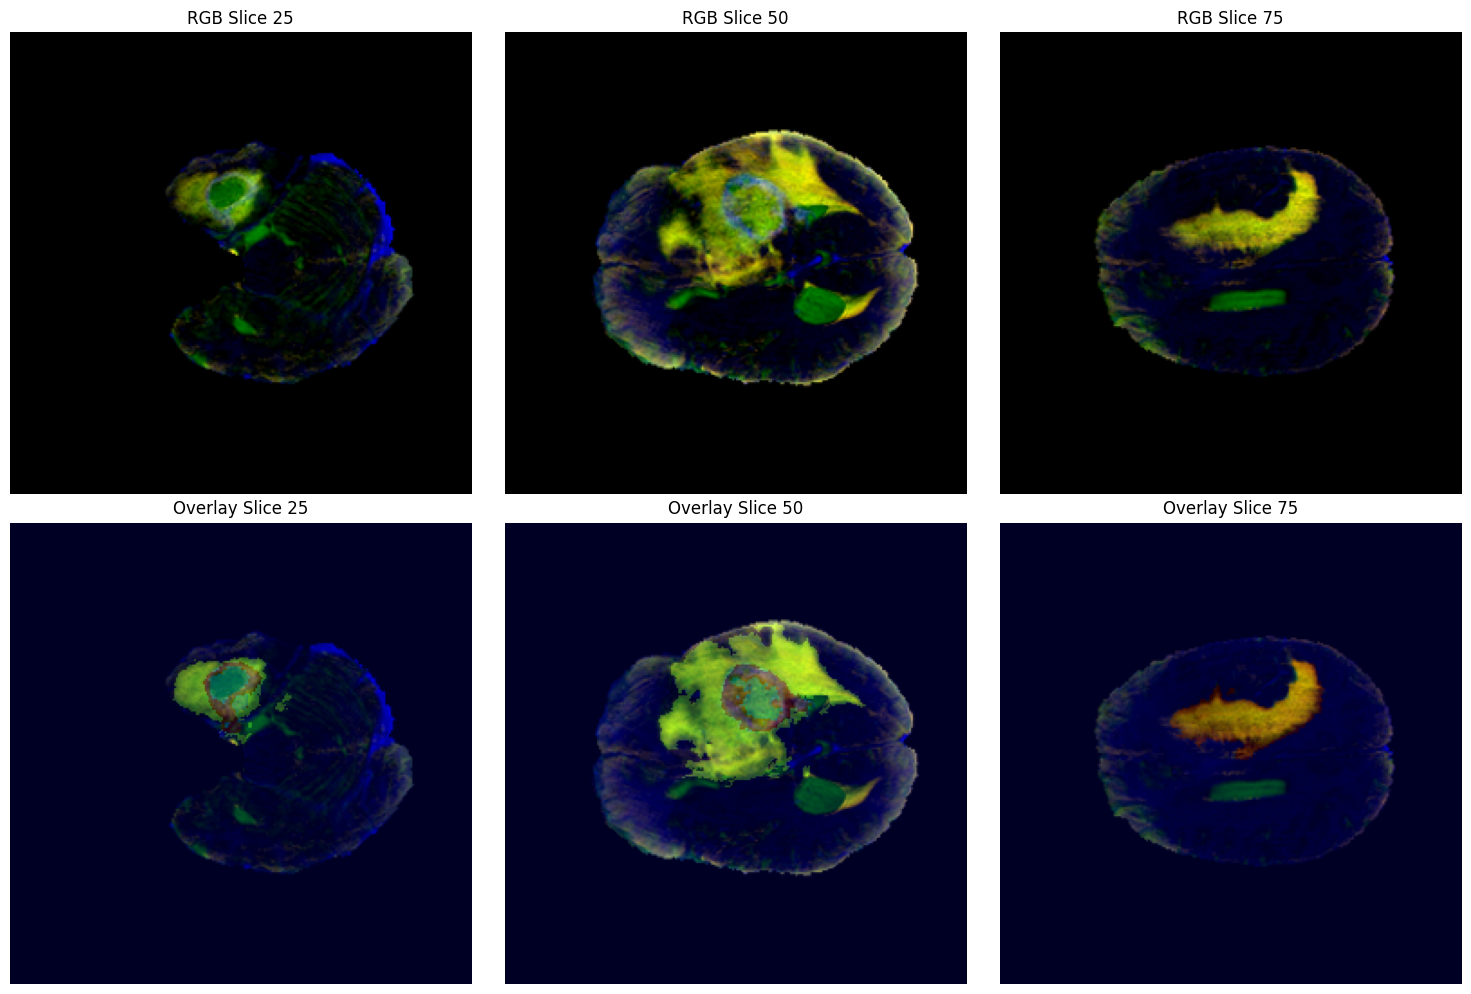

In [ ]:
# ============================================
# Cell 3 – Convert BraTS volumes to RGB slices + masks (256×256)
#           and save to Google Drive (RGB_DIR) – resumable
# ============================================

import os
from glob import glob

import numpy as np
import nibabel as nib
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt

print("=" * 80)
print("TRANSFORMING BRATS2020 TO RGB (TRAINING SLICES ONLY)")
print("=" * 80)
print("Input TRAIN_DATASET_PATH:", TRAIN_DATASET_PATH)

# البحث عن جميع الحالات
cases = sorted(glob(os.path.join(TRAIN_DATASET_PATH, "BraTS20_Training_*")))
print(f"Found {len(cases)} cases")

# إعدادات الصورة
IMG_SIZE = 256
VOLUME_SLICES = 100
VOLUME_START_AT = 22
END_SLICE = VOLUME_START_AT + VOLUME_SLICES  # 22..121

OUTPUT_DIR = RGB_DIR  # نحفظ مباشرة على Google Drive
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Processing slices: {VOLUME_START_AT} to {END_SLICE - 1}")
print(f"Output size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Total slices per case to save: {VOLUME_SLICES}")
print("OUTPUT_DIR:", OUTPUT_DIR)

# --------------------------------------------------------
# Step 1 – Collect healthy slices to build templates
# --------------------------------------------------------

def collect_healthy_slices(cases_list, max_slices=200):
    healthy_flair, healthy_t2, healthy_t1c = [], [], []

    for case_path in tqdm(cases_list[:50], desc="Collecting healthy slices"):
        case_name = os.path.basename(case_path)
        try:
            flair = nib.load(os.path.join(case_path, f"{case_name}_flair.nii")).get_fdata()
            t2    = nib.load(os.path.join(case_path, f"{case_name}_t2.nii")).get_fdata()
            t1c   = nib.load(os.path.join(case_path, f"{case_name}_t1ce.nii")).get_fdata()
            seg   = nib.load(os.path.join(case_path, f"{case_name}_seg.nii")).get_fdata()

            for slice_idx in range(seg.shape[2]):
                if np.sum(seg[:, :, slice_idx]) == 0:  # لا يوجد ورم
                    # استبعاد السلايس الفارغة تمامًا
                    if np.sum(flair[:, :, slice_idx] > 0) > 10_000:
                        healthy_flair.append(flair[:, :, slice_idx])
                        healthy_t2.append(t2[:, :, slice_idx])
                        healthy_t1c.append(t1c[:, :, slice_idx])

                        if len(healthy_flair) >= max_slices:
                            return healthy_flair, healthy_t2, healthy_t1c
        except Exception as e:
            print(f"[WARN] skipping {case_name}: {e}")
            continue

    return healthy_flair, healthy_t2, healthy_t1c

print("\nStep 1: Creating healthy templates...")

healthy_flair, healthy_t2, healthy_t1c = collect_healthy_slices(cases, max_slices=200)

if len(healthy_flair) == 0:
    raise RuntimeError("لم يتم جمع أي سلايس سليمة لبناء القوالب.")

HMFLAIR = np.mean(healthy_flair, axis=0)
HMT2    = np.mean(healthy_t2, axis=0)
HMT1c   = np.mean(healthy_t1c, axis=0)

print(f"✓ Created templates from {len(healthy_flair)} healthy slices")
print(f"Template shape: {HMFLAIR.shape}")

# --------------------------------------------------------
# Step 2 – Transformation function (equations 1 & 2)
# --------------------------------------------------------

def transform_to_rgb(flair, t2, t1c,
                     HMFLAIR, HMT2, HMT1c,
                     target_size=256):
    """
    تحويل السلايس إلى صورة RGB باستخدام معادلات Section 2.1
    """
    alpha = 5 / 6  # Eq. (1)
    DFLAIR = np.clip(flair - alpha * HMFLAIR, 0, None)
    DT2    = np.clip(t2    - alpha * HMT2,    0, None)
    DT1c   = np.clip(t1c   - alpha * HMT1c,   0, None)

    beta = 0.5  # Eq. (2)
    h, w = DFLAIR.shape
    rgb = np.zeros((h, w, 3), dtype=np.float32)

    rgb[:, :, 0] = DFLAIR                      # R
    rgb[:, :, 1] = DFLAIR * beta + DT2 * beta  # G
    rgb[:, :, 2] = DT1c                        # B

    # Normalization إلى 0–255 لكل قناة
    for i in range(3):
        ch = rgb[:, :, i]
        if ch.max() > ch.min():
            rgb[:, :, i] = (ch - ch.min()) / (ch.max() - ch.min()) * 255.0

    rgb = rgb.astype(np.uint8)
    rgb = cv2.resize(rgb, (target_size, target_size), interpolation=cv2.INTER_CUBIC)
    return rgb

# --------------------------------------------------------
# Step 3 – Process all cases (resumable)
# --------------------------------------------------------

print("\nStep 2: Processing cases and saving RGB + masks to Google Drive...")

processed, skipped, errors = 0, 0, 0

for case_path in tqdm(cases, desc="Transforming cases"):
    case_name = os.path.basename(case_path)
    rgb_out_path = os.path.join(OUTPUT_DIR, f"{case_name}_rgb.npy")
    seg_out_path = os.path.join(OUTPUT_DIR, f"{case_name}_seg.npy")

    # استكمال: إذا الملفات موجودة، نتخطى هذه الحالة
    if os.path.exists(rgb_out_path) and os.path.exists(seg_out_path):
        skipped += 1
        continue

    try:
        flair_vol = nib.load(os.path.join(case_path, f"{case_name}_flair.nii")).get_fdata()
        t2_vol    = nib.load(os.path.join(case_path, f"{case_name}_t2.nii")).get_fdata()
        t1c_vol   = nib.load(os.path.join(case_path, f"{case_name}_t1ce.nii")).get_fdata()
        seg_vol   = nib.load(os.path.join(case_path, f"{case_name}_seg.nii")).get_fdata()

        rgb_slices = np.zeros((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)
        seg_slices = np.zeros((VOLUME_SLICES, IMG_SIZE, IMG_SIZE), dtype=np.uint8)

        for idx, slice_idx in enumerate(range(VOLUME_START_AT, END_SLICE)):
            flair_slice = flair_vol[:, :, slice_idx]
            t2_slice    = t2_vol[:, :, slice_idx]
            t1c_slice   = t1c_vol[:, :, slice_idx]
            seg_slice   = seg_vol[:, :, slice_idx]

            rgb_slice = transform_to_rgb(
                flair_slice, t2_slice, t1c_slice,
                HMFLAIR, HMT2, HMT1c,
                target_size=IMG_SIZE
            )

            seg_resized = cv2.resize(
                seg_slice.astype(np.uint8),
                (IMG_SIZE, IMG_SIZE),
                interpolation=cv2.INTER_NEAREST
            )

            rgb_slices[idx] = rgb_slice
            seg_slices[idx] = seg_resized

        np.save(rgb_out_path, rgb_slices)
        np.save(seg_out_path, seg_slices)
        processed += 1

    except Exception as e:
        errors += 1
        print(f"\n[ERROR] {case_name}: {e}")
        continue

print("\n" + "=" * 80)
print("TRANSFORMATION COMPLETE")
print("=" * 80)
print(f"Processed cases : {processed}")
print(f"Skipped (already done): {skipped}")
print(f"Errors          : {errors}")
print("Output directory:", OUTPUT_DIR)

# معاينة سريعة لعينة
if processed + skipped > 0:
    sample_file = [f for f in os.listdir(OUTPUT_DIR) if f.endswith("_rgb.npy")][0]
    sample_rgb = np.load(os.path.join(OUTPUT_DIR, sample_file))
    sample_seg = np.load(os.path.join(OUTPUT_DIR, sample_file.replace("_rgb.npy", "_seg.npy")))

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    for i, slice_idx in enumerate([25, 50, 75]):
        axes[0, i].imshow(sample_rgb[slice_idx])
        axes[0, i].set_title(f"RGB Slice {slice_idx}")
        axes[0, i].axis("off")

        axes[1, i].imshow(sample_rgb[slice_idx])
        axes[1, i].imshow(sample_seg[slice_idx], alpha=0.3, cmap="jet")
        axes[1, i].set_title(f"Overlay Slice {slice_idx}")
        axes[1, i].axis("off")

    plt.tight_layout()
    plt.show()


In [ ]:
!pip install seaborn

In [ ]:
# ============================================
# Cell 4 – U-Net Segmentation:
# train / continue / finetune / eval
# + periodic checkpoints in Google Drive
# + auto-download best model after training (Colab)
# + full metrics, benchmarking, visualizations
# ============================================

import os
import csv
import random
from glob import glob
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
)

import seaborn as sns  # لو غير متوفر: !pip install seaborn

print("TensorFlow version:", tf.__version__)

# محاولة استيراد أداة التحميل من Colab (للتنزيل التلقائي بعد التدريب)
try:
    from google.colab import files
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# ----------------------------------
# 0) التحقق من وجود المتغيرات الأساسية
# ----------------------------------
required_globals = ["PROJECT_DIR", "RGB_DIR", "CHECKPOINT_DIR"]
missing = [name for name in required_globals if name not in globals()]
if missing:
    raise RuntimeError(
        f"هذه الخلية تحتاج المتغيرات التالية قبل التشغيل: {missing}\n"
        "تأكد أنك شغّلت خلية الـ setup (Cell 0) وخلية المسارات (cell2) في نفس الـ runtime."
    )

# MODE يمكن تغييره حسب الحاجة: "train" أو "continue" أو "finetune" أو "eval"
MODE = "train"   # غيّرها يدويًا: "train" أول تشغيل، "continue" / "finetune" لاحقًا

# إعداد مجلد التقييم داخل المشروع
EVAL_DIR = os.path.join(PROJECT_DIR, "evaluation")
os.makedirs(EVAL_DIR, exist_ok=True)
print("EVAL_DIR:", EVAL_DIR)

# ----------------------------------
# 1) تحميل ملفات .npy وتقسيم Train/Val
# ----------------------------------

IMG_SIZE = 256
BATCH_SIZE = 4
MAX_SLICES_PER_CASE = 40  # عدد السلايس المستخدمة من كل case لتقليل الحمل

rgb_files = sorted(glob(os.path.join(RGB_DIR, "BraTS20_Training_*_rgb.npy")))
seg_files = [f.replace("_rgb.npy", "_seg.npy") for f in rgb_files]

pairs = []
for rgb, seg in zip(rgb_files, seg_files):
    if os.path.exists(seg):
        pairs.append((rgb, seg))
    else:
        print("[WARN] Missing seg for:", rgb)

print(f"Found {len(rgb_files)} RGB volumes, usable pairs: {len(pairs)}")

if len(pairs) == 0:
    raise RuntimeError("لا توجد ملفات npy في RGB_DIR. تأكد من نجاح خلية 3.")

train_pairs, val_pairs = train_test_split(pairs, test_size=0.15, random_state=42)
print(f"Train cases: {len(train_pairs)}, Val cases: {len(val_pairs)}")

# ----------------------------------
# 2) Generators للـ slices
# ----------------------------------
def slice_generator(pairs_list,
                    batch_size=BATCH_SIZE,
                    max_slices_per_case=MAX_SLICES_PER_CASE,
                    shuffle=True,
                    binary_mask=True):
    while True:
        if shuffle:
            random.shuffle(pairs_list)

        for rgb_path, seg_path in pairs_list:
            rgb_vol = np.load(rgb_path)        # (N,256,256,3)
            seg_vol = np.load(seg_path)        # (N,256,256)

            num_slices = rgb_vol.shape[0]
            indices = np.arange(num_slices)

            if max_slices_per_case is not None and max_slices_per_case < num_slices:
                indices = np.linspace(
                    0, num_slices - 1, max_slices_per_case, dtype=int
                )

            if shuffle:
                np.random.shuffle(indices)

            batch_imgs = []
            batch_masks = []

            for idx in indices:
                img = rgb_vol[idx].astype("float32") / 255.0
                mask = seg_vol[idx].astype("float32")

                if binary_mask:
                    mask = (mask > 0).astype("float32")

                mask = np.expand_dims(mask, axis=-1)

                batch_imgs.append(img)
                batch_masks.append(mask)

                if len(batch_imgs) == batch_size:
                    yield np.array(batch_imgs), np.array(batch_masks)
                    batch_imgs = []
                    batch_masks = []


def count_steps(pairs_list, max_slices_per_case=MAX_SLICES_PER_CASE,
                batch_size=BATCH_SIZE):
    total_slices = len(pairs_list) * (max_slices_per_case or 100)
    return max(1, total_slices // batch_size)


train_steps = count_steps(train_pairs)
val_steps   = count_steps(val_pairs)

print(f"Approx train steps/epoch: {train_steps}, val steps/epoch: {val_steps}")

train_gen = slice_generator(train_pairs)
val_gen   = slice_generator(val_pairs, shuffle=False)

# ----------------------------------
# 3) بناء U-Net + metrics/loss
# ----------------------------------
def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    return x


def build_unet(input_shape=(IMG_SIZE, IMG_SIZE, 3), base_filters=32):
    inputs = layers.Input(shape=input_shape)

    c1 = conv_block(inputs, base_filters)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = conv_block(p1, base_filters * 2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = conv_block(p2, base_filters * 4)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = conv_block(p3, base_filters * 8)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    bn = conv_block(p4, base_filters * 16)

    u4 = layers.Conv2DTranspose(base_filters * 8, 2, strides=2, padding="same")(bn)
    u4 = layers.concatenate([u4, c4])
    c5 = conv_block(u4, base_filters * 8)

    u3 = layers.Conv2DTranspose(base_filters * 4, 2, strides=2, padding="same")(c5)
    u3 = layers.concatenate([u3, c3])
    c6 = conv_block(u3, base_filters * 4)

    u2 = layers.Conv2DTranspose(base_filters * 2, 2, strides=2, padding="same")(c6)
    u2 = layers.concatenate([u2, c2])
    c7 = conv_block(u2, base_filters * 2)

    u1 = layers.Conv2DTranspose(base_filters, 2, strides=2, padding="same")(c7)
    u1 = layers.concatenate([u1, c1])
    c8 = conv_block(u1, base_filters)

    outputs = layers.Conv2D(1, 1, activation="sigmoid")(c8)

    model = models.Model(inputs, outputs, name="BrainTumorSegNetRGB")
    return model


def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2.0 * intersection + smooth) / (
        tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth
    )


def iou_metric(y_true, y_pred, smooth=1e-6):
    y_pred_bin = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred_bin)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred_bin) - intersection
    return (intersection + smooth) / (union + smooth)


def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return bce + (1.0 - dice_coefficient(y_true, y_pred))


model_seg = build_unet()

# مسارات الـ checkpoints في Google Drive
checkpoint_path_best = os.path.join(CHECKPOINT_DIR, "brain_tumor_segmentation_best.keras")
checkpoint_path_periodic = os.path.join(
    CHECKPOINT_DIR,
    "brain_tumor_seg_epoch_{epoch:02d}_val{val_loss:.4f}.keras"
)

# مسار قديم للرجوع للخلف compat
old_checkpoint_path = os.path.join(CHECKPOINT_DIR, "brain_tumor_segmentation.keras")

# تحميل وزن سابق إن وجد
if os.path.exists(checkpoint_path_best):
    print("Found existing BEST checkpoint:", checkpoint_path_best)
    model_seg.load_weights(checkpoint_path_best)
elif os.path.exists(old_checkpoint_path):
    print("Found OLD checkpoint:", old_checkpoint_path)
    model_seg.load_weights(old_checkpoint_path)
else:
    print("No existing checkpoint found. Starting from scratch.")

# ضبط عدد الـ epochs و الـ LR حسب MODE
if MODE == "train":
    epochs_to_run = 20
    lr = 1e-4
elif MODE == "continue":
    epochs_to_run = 10
    lr = 1e-4
elif MODE == "finetune":
    epochs_to_run = 8
    lr = 5e-5   # LR أقل لفترة fine-tuning
elif MODE == "eval":
    epochs_to_run = 0
    lr = 1e-4
else:
    raise ValueError("MODE يجب أن يكون 'train' أو 'continue' أو 'finetune' أو 'eval'.")

print("\nModel summary:")
model_seg.summary()

model_seg.compile(
    optimizer=Adam(learning_rate=lr),
    loss=bce_dice_loss,
    metrics=["accuracy", iou_metric, dice_coefficient],
)

# ----------------------------------
# 4) التدريب (إن لزم) + الحفظ الدوري + التحميل التلقائي
# ----------------------------------
history = None
if MODE in ["train", "continue", "finetune"] and epochs_to_run > 0:
    callbacks = [
        EarlyStopping(
            monitor="val_loss",
            patience=5,
            restore_best_weights=True,
            verbose=1,
        ),
        # 1) أفضل موديل فقط – يُستخدم للاستكمال والتحميل
        ModelCheckpoint(
            checkpoint_path_best,
            monitor="val_loss",
            save_best_only=True,
            verbose=1,
        ),
        # 2) Checkpoint دوري لكل Epoch باسم مختلف (للتتبع التاريخي)
        ModelCheckpoint(
            filepath=checkpoint_path_periodic,
            monitor="val_loss",
            save_best_only=False,
            verbose=1,
        ),
    ]

    print(f"\nStarting training (MODE={MODE}, epochs={epochs_to_run}, lr={lr})...")
    history = model_seg.fit(
        train_gen,
        steps_per_epoch=train_steps,
        validation_data=val_gen,
        validation_steps=val_steps,
        epochs=epochs_to_run,
        callbacks=callbacks,
        verbose=1,
    )

    print("\nTraining finished.")
    print("Best model saved to:", checkpoint_path_best)
    print("Periodic checkpoints saved to:", CHECKPOINT_DIR)

    # تحميل تلقائي لأفضل موديل إلى جهازك (في Colab فقط)
    if IN_COLAB and os.path.exists(checkpoint_path_best):
        print("\nAuto-downloading best model to your laptop ...")
        files.download(checkpoint_path_best)
    else:
        print("\n[Info] Not in Colab or best checkpoint not found for download.")
else:
    print("\n[MODE=eval] Skipping training, using existing checkpoint as-is.")

# ----------------------------------
# 5) تقييم شامل + تخزين y_true/y_pred
# ----------------------------------
print("\n=== Keras evaluate() on validation generator ===")
eval_results = model_seg.evaluate(val_gen, steps=val_steps, verbose=1)
metric_names = model_seg.metrics_names

for name, value in zip(metric_names, eval_results):
    print(f"{name}: {value:.4f}")

# حفظ نتائج evaluate في ملف CSV
eval_csv_path = os.path.join(EVAL_DIR, "keras_evaluate_results.csv")
with open(eval_csv_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["metric", "value"])
    for name, value in zip(metric_names, eval_results):
        writer.writerow([name, float(value)])

print("Saved Keras evaluate() metrics to:", eval_csv_path)

# ----------------------------------
# 5.1) تجميع y_true / y_pred + عينات للعرض البصري
# ----------------------------------
print("\nCollecting predictions on validation set ...")

all_y_true = []
all_y_pred = []
sample_images = []
sample_true_masks = []
sample_pred_masks = []
NUM_SAMPLES_VIS = 6

max_batches_for_eval = val_steps  # يمكن تقليله لو الذاكرة لا تكفي
val_gen_for_eval = slice_generator(val_pairs, shuffle=False)

for b in range(max_batches_for_eval):
    x_batch, y_batch = next(val_gen_for_eval)
    y_pred_batch = model_seg.predict(x_batch, verbose=0)

    all_y_true.append(y_batch)
    all_y_pred.append(y_pred_batch)

    # حفظ عينات للعرض البصري
    if len(sample_images) < NUM_SAMPLES_VIS:
        remain = NUM_SAMPLES_VIS - len(sample_images)
        k = min(remain, x_batch.shape[0])
        sample_images.extend(list(x_batch[:k]))
        sample_true_masks.extend(list(y_batch[:k]))
        sample_pred_masks.extend(list(y_pred_batch[:k]))

all_y_true = np.concatenate(all_y_true, axis=0)  # (N,256,256,1)
all_y_pred = np.concatenate(all_y_pred, axis=0)  # (N,256,256,1)

print("all_y_true.shape:", all_y_true.shape)
print("all_y_pred.shape:", all_y_pred.shape)

# حفظ y_true/y_pred كملفات npy للرجوع لها لاحقًا
np.save(os.path.join(EVAL_DIR, "val_y_true.npy"), all_y_true)
np.save(os.path.join(EVAL_DIR, "val_y_pred.npy"), all_y_pred)
print("Saved val_y_true.npy and val_y_pred.npy into:", EVAL_DIR)

# تحويل إلى 1D vectors (pixels)
y_true_flat = all_y_true.reshape(-1)
y_pred_flat = all_y_pred.reshape(-1)

# ----------------------------------
# 5.2) دالة عامة لحساب المقاييس لثريشولد معيّن
# ----------------------------------
def compute_binary_pixel_metrics(y_true_flat, y_prob_flat, thr):
    y_bin = (y_prob_flat >= thr).astype(np.uint8)

    tp = ((y_true_flat == 1) & (y_bin == 1)).sum()
    tn = ((y_true_flat == 0) & (y_bin == 0)).sum()
    fp = ((y_true_flat == 0) & (y_bin == 1)).sum()
    fn = ((y_true_flat == 1) & (y_bin == 0)).sum()

    accuracy = (tp + tn) / (tp + tn + fp + fn + 1e-6)
    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    f1 = 2 * precision * recall / (precision + recall + 1e-6)
    dice_val = f1  # في binary segmentation، Dice == F1
    iou_val = tp / (tp + fp + fn + 1e-6)

    return {
        "threshold": thr,
        "tp": int(tp),
        "tn": int(tn),
        "fp": int(fp),
        "fn": int(fn),
        "accuracy": float(accuracy),
        "precision": float(precision),
        "recall": float(recall),
        "f1": float(f1),
        "dice": float(dice_val),
        "iou": float(iou_val),
    }

# ----------------------------------
# 5.3) Confusion Matrix ملوّنة عند threshold=0.5
# ----------------------------------
main_threshold = 0.5
main_metrics = compute_binary_pixel_metrics(y_true_flat, y_pred_flat, main_threshold)
y_pred_bin_flat = (y_pred_flat >= main_threshold).astype(np.uint8)

cm = confusion_matrix(y_true_flat, y_pred_bin_flat, labels=[0, 1])
print("\nConfusion matrix (rows=true, cols=pred) at threshold=0.5:")
print(cm)

cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".4f",
    cmap="Blues",
    xticklabels=["Background", "Tumor"],
    yticklabels=["Background", "Tumor"],
    cbar=True,
)

plt.title("Confusion Matrix (Pixel-wise, normalized, thr=0.5)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()

cm_path = os.path.join(EVAL_DIR, "confusion_matrix_normalized_thr_0.5.png")
plt.savefig(cm_path, dpi=150)
plt.show()
print("Saved confusion matrix to:", cm_path)

# ----------------------------------
# 5.4) ROC curve + AUC
# ----------------------------------
fpr, tpr, roc_thresholds = roc_curve(y_true_flat, y_pred_flat)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Pixel-wise)")
plt.legend(loc="lower right")
plt.tight_layout()

roc_path = os.path.join(EVAL_DIR, "roc_curve.png")
plt.savefig(roc_path, dpi=150)
plt.show()
print("Saved ROC curve to:", roc_path)

# ----------------------------------
# 5.5) Precision-Recall curve + AUC
# ----------------------------------
precision_vals, recall_vals, pr_thresholds = precision_recall_curve(
    y_true_flat, y_pred_flat
)
pr_auc = auc(recall_vals, precision_vals)

plt.figure(figsize=(6, 5))
plt.plot(
    recall_vals,
    precision_vals,
    label=f"PR curve (AUC = {pr_auc:.4f})",
)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Pixel-wise)")
plt.legend(loc="lower left")
plt.tight_layout()

pr_path = os.path.join(EVAL_DIR, "precision_recall_curve.png")
plt.savefig(pr_path, dpi=150)
plt.show()
print("Saved Precision-Recall curve to:", pr_path)

# ----------------------------------
# 5.6) مقاييس تفصيلية عند threshold=0.5 + CSV
# ----------------------------------
print("\n=== Metrics at threshold = 0.5 ===")
for k, v in main_metrics.items():
    if k in ["tp", "tn", "fp", "fn"]:
        print(f"{k.upper()}: {v}")
    else:
        print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")

print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR  AUC: {pr_auc:.4f}")

metrics_csv_path = os.path.join(EVAL_DIR, "pixel_metrics_threshold_0.5.csv")
with open(metrics_csv_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["metric", "value"])
    for k in ["tp", "tn", "fp", "fn", "accuracy", "precision", "recall", "f1", "dice", "iou"]:
        writer.writerow([k, main_metrics[k]])
    writer.writerow(["roc_auc", float(roc_auc)])
    writer.writerow(["pr_auc", float(pr_auc)])

print("Saved detailed metrics to:", metrics_csv_path)

# ----------------------------------
# 5.7) Benchmarking: sweep over thresholds + منحنى F1/Dice و IoU
# ----------------------------------
thresholds = np.linspace(0.1, 0.9, 17)  # 0.1, 0.15, ..., 0.9
sweep_metrics = []

for thr in thresholds:
    m = compute_binary_pixel_metrics(y_true_flat, y_pred_flat, thr)
    sweep_metrics.append(m)

sweep_csv_path = os.path.join(EVAL_DIR, "threshold_sweep_metrics.csv")
with open(sweep_csv_path, "w", newline="") as f:
    writer = csv.writer(f)
    header = ["threshold", "tp", "tn", "fp", "fn",
              "accuracy", "precision", "recall", "f1", "dice", "iou"]
    writer.writerow(header)
    for m in sweep_metrics:
        writer.writerow([m[h] for h in header])

print("Saved threshold sweep metrics to:", sweep_csv_path)

# رسم F1 / Dice / IoU مقابل threshold
plt.figure(figsize=(7, 5))
plt.plot(thresholds, [m["f1"] for m in sweep_metrics], label="F1 / Dice")
plt.plot(thresholds, [m["iou"] for m in sweep_metrics], label="IoU")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Benchmarking across thresholds")
plt.legend()
plt.grid(True)
plt.tight_layout()

sweep_plot_path = os.path.join(EVAL_DIR, "threshold_sweep_plot.png")
plt.savefig(sweep_plot_path, dpi=150)
plt.show()
print("Saved threshold sweep plot to:", sweep_plot_path)

# أفضل threshold حسب F1
best_by_f1 = max(sweep_metrics, key=lambda d: d["f1"])
print("\nBest threshold by F1/Dice:")
for k in ["threshold", "accuracy", "precision", "recall", "f1", "dice", "iou"]:
    print(f"{k}: {best_by_f1[k]:.4f}" if k != "threshold" else f"{k}: {best_by_f1[k]:.3f}")

# ----------------------------------
# 5.8) أمثلة بصرية (gallery): الصورة + GT + Prediction
# ----------------------------------
gallery_dir = os.path.join(EVAL_DIR, "gallery")
os.makedirs(gallery_dir, exist_ok=True)

thr_for_vis = main_threshold  # يمكن تغييره إلى best_by_f1["threshold"] لو رغبت
num_samples = len(sample_images)

print(f"\nSaving qualitative examples for {num_samples} validation slices ...")

for i in range(num_samples):
    img = sample_images[i]
    gt_mask = sample_true_masks[i][:, :, 0]
    pred_prob = sample_pred_masks[i][:, :, 0]
    pred_mask = (pred_prob >= thr_for_vis).astype(float)

    plt.figure(figsize=(10, 3))

    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("RGB slice")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(img)
    plt.imshow(gt_mask, alpha=0.3, cmap="jet")
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(img)
    plt.imshow(pred_mask, alpha=0.3, cmap="jet")
    plt.title(f"Prediction (thr={thr_for_vis:.2f})")
    plt.axis("off")

    plt.tight_layout()
    fig_path = os.path.join(gallery_dir, f"sample_{i+1}.png")
    plt.savefig(fig_path, dpi=150)
    plt.show()

print("Saved qualitative gallery images in:", gallery_dir)

# ----------------------------------
# 5.9) تسجيل إعدادات التجربة في ملف experiment_log.csv
# ----------------------------------
log_path = os.path.join(EVAL_DIR, "experiment_log.csv")
now_str = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

with open(log_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow([
        "timestamp",
        "mode",
        "epochs_ran",
        "learning_rate",
        "img_size",
        "batch_size",
        "max_slices_per_case",
        "train_cases",
        "val_cases",
        "train_steps",
        "val_steps",
        "main_thr",
        "best_thr_f1",
        "accuracy_main",
        "precision_main",
        "recall_main",
        "f1_main",
        "dice_main",
        "iou_main",
        "roc_auc",
        "pr_auc",
        "checkpoint_best",
        "eval_dir",
        "gallery_dir",
    ])
    writer.writerow([
        now_str,
        MODE,
        epochs_to_run,
        lr,
        IMG_SIZE,
        BATCH_SIZE,
        MAX_SLICES_PER_CASE,
        len(train_pairs),
        len(val_pairs),
        train_steps,
        val_steps,
        main_threshold,
        best_by_f1["threshold"],
        main_metrics["accuracy"],
        main_metrics["precision"],
        main_metrics["recall"],
        main_metrics["f1"],
        main_metrics["dice"],
        main_metrics["iou"],
        roc_auc,
        pr_auc,
        checkpoint_path_best,
        EVAL_DIR,
        gallery_dir,
    ])

print("Experiment logged to:", log_path)

print("\n✓ Completed pipeline (MODE =", MODE, ")")
print("All evaluation and checkpoints are in:")
print("  CHECKPOINT_DIR:", CHECKPOINT_DIR)
print("  EVAL_DIR      :", EVAL_DIR)


TensorFlow version: 2.19.0


RuntimeError: هذه الخلية تحتاج المتغيرات التالية قبل التشغيل: ['PROJECT_DIR', 'RGB_DIR', 'CHECKPOINT_DIR']
تأكد أنك شغّلت خلية الـ setup (Cell 0) وخلية المسارات (cell2) في نفس الـ runtime.

Saved threshold metrics CSV to: /content/drive/MyDrive/brats_brainvision_brats2020/evaluation/threshold_metrics.csv


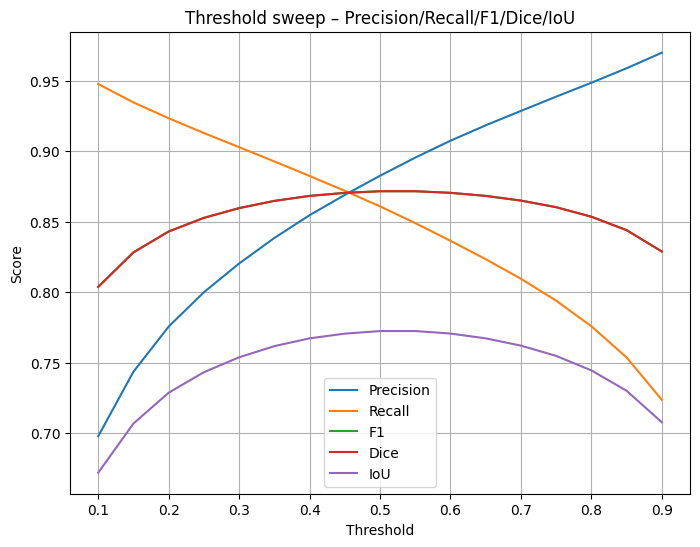

Saved threshold metrics plot to: /content/drive/MyDrive/brats_brainvision_brats2020/evaluation/threshold_metrics.png


In [ ]:
# ============================================
# Cell 5 – Threshold sweep (Precision/Recall/F1/Dice/IoU vs threshold)
# ============================================

import os
import numpy as np
import matplotlib.pyplot as plt
import csv

y_true_flat_path = os.path.join(EVAL_DIR, "y_true_flat.npy")
y_pred_prob_flat_path = os.path.join(EVAL_DIR, "y_pred_prob_flat.npy")

if not (os.path.exists(y_true_flat_path) and os.path.exists(y_pred_prob_flat_path)):
    raise RuntimeError("يجب تشغيل خلية 4 أولًا لتوليد y_true_flat.npy و y_pred_prob_flat.npy")

y_true_flat = np.load(y_true_flat_path).astype("float32")
y_pred_prob_flat = np.load(y_pred_prob_flat_path).astype("float32")

thresholds = np.linspace(0.1, 0.9, 17)  # من 0.1 إلى 0.9 بخطوة 0.05 تقريبًا
eps = 1e-7

rows = []
for thr in thresholds:
    y_pred_bin = (y_pred_prob_flat > thr).astype("int32")
    tp = np.sum((y_true_flat == 1) & (y_pred_bin == 1))
    fp = np.sum((y_true_flat == 0) & (y_pred_bin == 1))
    fn = np.sum((y_true_flat == 1) & (y_pred_bin == 0))

    precision = tp / (tp + fp + eps)
    recall    = tp / (tp + fn + eps)
    f1        = 2 * precision * recall / (precision + recall + eps)
    dice      = f1  # في binary segmentation f1 = dice للـ pixel-level
    iou       = tp / (tp + fp + fn + eps)

    rows.append([thr, precision, recall, f1, dice, iou])

# حفظ في CSV
thr_csv_path = os.path.join(EVAL_DIR, "threshold_metrics.csv")
with open(thr_csv_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["threshold", "precision", "recall", "f1", "dice", "iou"])
    writer.writerows(rows)

print("Saved threshold metrics CSV to:", thr_csv_path)

# رسم curves
thresholds = np.array([r[0] for r in rows])
precisions = np.array([r[1] for r in rows])
recalls    = np.array([r[2] for r in rows])
f1s        = np.array([r[3] for r in rows])
dices      = np.array([r[4] for r in rows])
ious       = np.array([r[5] for r in rows])

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, f1s, label="F1")
plt.plot(thresholds, dices, label="Dice")
plt.plot(thresholds, ious, label="IoU")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold sweep – Precision/Recall/F1/Dice/IoU")
plt.grid(True)
plt.legend()
thr_plot_path = os.path.join(EVAL_DIR, "threshold_metrics.png")
plt.savefig(thr_plot_path, dpi=150)
plt.show()

print("Saved threshold metrics plot to:", thr_plot_path)


In [ ]:
# ============================================
# Cell 6 – Build segmentation gallery (RGB + GT + Prediction)
#           for a set of random slices – saved to GALLERY_DIR
# ============================================

import os
import numpy as np
import matplotlib.pyplot as plt
import random

# نستخدم نفس generators والموديل من خلية 4
# (تأكد أن خلية 4 تم تشغيلها في نفس الـ runtime)

if "model_seg" not in globals():
    raise RuntimeError("يجب تشغيل خلية 4 أولًا لتحميل الموديل model_seg.")

num_cases_to_sample = 4       # عدد الحالات
num_slices_per_case = 3       # عدد السلايس من كل حالة

print("Building gallery...")
os.makedirs(GALLERY_DIR, exist_ok=True)

selected_pairs = random.sample(val_pairs, min(num_cases_to_sample, len(val_pairs)))

for case_idx, (rgb_path, seg_path) in enumerate(selected_pairs, start=1):
    case_name = os.path.basename(rgb_path).replace("_rgb.npy", "")
    rgb_vol = np.load(rgb_path).astype("float32") / 255.0
    seg_vol = np.load(seg_path).astype("float32")

    total_slices = rgb_vol.shape[0]
    slice_indices = np.linspace(0, total_slices - 1,
                                num_slices_per_case, dtype=int)

    fig, axes = plt.subplots(num_slices_per_case, 3,
                             figsize=(10, 3 * num_slices_per_case))

    if num_slices_per_case == 1:
        axes = np.expand_dims(axes, axis=0)

    for i, idx in enumerate(slice_indices):
        img = rgb_vol[idx]
        mask = (seg_vol[idx] > 0).astype("float32")

        pred = model_seg.predict(np.expand_dims(img, axis=0), verbose=0)[0, :, :, 0]
        pred_bin = (pred > 0.5).astype("float32")

        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f"Slice {idx} – RGB")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(mask, cmap="gray")
        axes[i, 1].set_title("Ground Truth")
        axes[i, 1].axis("off")

        axes[i, 2].imshow(img)
        axes[i, 2].imshow(pred_bin, alpha=0.4, cmap="jet")
        axes[i, 2].set_title("Prediction Overlay")
        axes[i, 2].axis("off")

    plt.tight_layout()
    out_path = os.path.join(GALLERY_DIR, f"{case_name}_gallery.png")
    plt.savefig(out_path, dpi=150)
    plt.close(fig)
    print("Saved gallery image:", out_path)

print("\n✓ Gallery images saved in:", GALLERY_DIR)
